In [ ]:

pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=aed29d22b77870299f6ddc19e3946b04ddf027d08ec675ea38ce794158e8a120
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product

import ta
from itertools import product
from sklearn.ensemble import IsolationForest

In [ ]:
import os

# Get current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /content


# Data Collection


In [ ]:
csv_file = 'train_data_0_20.csv'
csv_path = os.path.join(current_directory, csv_file)
print("Full Path of the CSV File:", csv_path)

# Read the CSV file
data = pd.read_csv(csv_path)
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data.head()

Full Path of the CSV File: /content/train_data_0_20.csv


<ipython-input-4-8fb6f6d27bac>:6: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_path)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,sentiment
0,2015-10-01,ARL,7.030000,7.030000,7.030000,7.030000,1300,3,0.143887,7.711643,6.701357,56.887952,-9.827596,18.536363,7.094667,6.268500,22.549999,0.0,0
1,2015-10-01,BH,243.279999,245.199997,238.273331,241.353332,8850,3,-4.967863,254.549970,240.808029,40.288793,-150.888171,28.459297,249.845555,267.082889,22.549999,0.0,0
2,2015-10-01,CIX,10.990000,10.990000,10.830000,7.353430,200,3,-0.012619,7.685737,7.304256,45.040564,-93.320721,20.168078,7.473885,7.577119,22.549999,0.0,0
3,2015-10-01,FDBC,23.333332,23.333332,23.333332,18.255781,0,3,0.222549,18.046982,16.483571,73.236650,320.645967,36.525050,17.178692,17.132404,22.549999,0.0,0
4,2015-10-01,GEF,32.040001,32.540001,31.040001,22.461304,293500,3,0.044349,25.739347,22.292050,45.435755,-15.270326,5.304819,22.890805,22.948372,22.549999,0.0,0


Add ATR and Price Change as new features

In [ ]:
# Define the function for calculating ATR and other indicators
def calculate_atr_pc(group):
    # Calculate the ATR
    group['ATR'] = ta.volatility.AverageTrueRange(
        high=group['high'],
        low=group['low'],
        close=group['close'],
        window=14  # Define your window size
    ).average_true_range()

    # Calculate the price change
    group['Price_Change'] = group['close'].diff()

    return group

# Apply the function to each group
data = data.groupby('tic', group_keys=False).apply(calculate_atr_pc)



# Filter out rows where ATR is zero (optional)
data = data[data['ATR'] != 0]

# Display the updated dataset with ATR
data.tail()


<ipython-input-5-4377303f55f8>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('tic', group_keys=False).apply(calculate_atr_pc)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,sentiment,ATR,Price_Change
38347,2024-09-18,STRS,27.410000,28.309999,26.280001,26.280001,13800,2,0.378013,28.013316,...,51.882147,130.492371,15.690076,25.004000,25.837167,18.23,13.37937,0.0,1.255661,-1.480000
38348,2024-09-18,SWKH,16.959999,17.299999,16.770000,16.950001,20000,2,-0.057518,17.668155,...,48.225863,-46.888029,9.608028,17.130333,17.090667,18.23,13.37937,0.0,0.454393,-0.099998
38349,2024-09-18,TCI,28.250000,28.920000,27.620001,27.620001,3000,2,-0.396883,30.630781,...,43.494571,-101.713401,18.301329,29.073333,29.319500,18.23,13.37937,0.0,0.822697,-0.869999
38350,2024-09-18,VABK,40.990002,41.209999,40.180000,41.040001,13800,2,1.288482,42.184776,...,62.731284,104.565840,28.385168,37.864954,36.354800,18.23,13.37937,0.0,1.292221,-0.160000
38351,2024-09-18,VALU,42.880001,44.700001,42.490002,44.700001,12000,2,0.194193,44.466663,...,53.666986,183.094744,7.058237,42.489000,43.618247,18.23,13.37937,0.0,1.791891,2.000000





# Plotting function

In [ ]:
def plot_anomalies(ticker, df_anomalies, prob_column, threshold):
    anomalies = df_anomalies[df_anomalies['tic'] == ticker].copy()

    anomalies['date'] = pd.to_datetime(anomalies['date']).dt.tz_localize(None)

    anomaly_points = anomalies[anomalies[prob_column] > threshold].copy()

    start_date = anomalies['date'].min().strftime('%Y-%m-%d')
    end_date = anomalies['date'].max().strftime('%Y-%m-%d')

    close_price_data = yf.download(ticker, start=start_date, end=end_date)

    if isinstance(close_price_data.columns, pd.MultiIndex):
        close_price_data.columns = close_price_data.columns.droplevel('Ticker')

    close_price_data.reset_index(inplace=True)
    close_price_data.rename(columns={'Date': 'date'}, inplace=True)
    close_price_data['date'] = pd.to_datetime(close_price_data['date']).dt.tz_localize(None)

    anomaly_points = anomaly_points.merge(close_price_data[['date', 'Close']], on='date', how='left')

    plt.figure(figsize=(14, 7))
    plt.plot(close_price_data['date'], close_price_data['Close'], label='Close Price')
    plt.scatter(anomaly_points['date'], anomaly_points['Close'], color='red', label='Anomaly', marker='^')
    plt.title(f'{ticker} Close Price with Anomalies (Threshold: {threshold})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [ ]:
# In this function, you can visulize anomalies

def plot_anomalies_2(ticker, df_anomalies,type):
    # Filter the data for the specified ticker
    anomalies = df_anomalies[df_anomalies['tic'] == ticker].copy()

    # Ensure 'date' is datetime and timezone-naive
    anomalies['date'] = pd.to_datetime(anomalies['date']).dt.tz_localize(None)

    # Filter for anomalies where 'DBSCAN_Anomaly' equals 1
    anomaly_points = anomalies[anomalies[type] == 1].copy()
    # anomaly_points = anomalies[anomalies['IsolationForest_Anomaly_Probability']>prob].copy()


    # Get date range
    start_date = anomalies['date'].min().strftime('%Y-%m-%d')
    end_date = anomalies['date'].max().strftime('%Y-%m-%d')

    # Download close price data
    close_price_data = yf.download(ticker, start=start_date, end=end_date)

    # Check if columns are MultiIndex and flatten them
    if isinstance(close_price_data.columns, pd.MultiIndex):
        # Drop the 'Ticker' level
        close_price_data.columns = close_price_data.columns.droplevel('Ticker')



    # Reset index to make 'Date' a column
    close_price_data.reset_index(inplace=True)
    close_price_data.rename(columns={'Date': 'date'}, inplace=True)

    # Ensure 'date' is datetime and timezone-naive
    close_price_data['date'] = pd.to_datetime(close_price_data['date']).dt.tz_localize(None)

    # Merge anomalies with close price data
    anomaly_points = anomaly_points.merge(close_price_data[['date', 'Close']], on='date', how='left')

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(close_price_data['date'], close_price_data['Close'], label='Close Price')
    plt.scatter(anomaly_points['date'], anomaly_points['Close'], color='red', label='Anomaly', marker='^')
    plt.title(f'{ticker} Close Price with Anomalies')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



# Data Scaling (in month)

In [ ]:

# Assuming df_scaled is already prepared with 'date' and 'month' columns
df_scaled = pd.DataFrame(data)
df_scaled['date'] = pd.to_datetime(df_scaled['date'], format='%Y/%m/%d')

# Extract the month from the 'date' column
df_scaled['month'] = df_scaled['date'].dt.to_period('M')
df_scaled['sentiment'] = pd.to_numeric(df_scaled['sentiment'], errors='coerce')

# List of features to scale (exclude 'sentiment' since it's non-numeric)
features_scaled = [
    'close',
    'volume',
    'macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma',
    'turbulence',
    'vix',
    'sentiment',
    'ATR',
    'Price_Change'
]


# Drop any rows with NaN values in the features (Optional if needed)
df_scaled = df_scaled.fillna(0)

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the selected features and store them in a new DataFrame
df_scaled_features = pd.DataFrame(scaler.fit_transform(df_scaled[features_scaled]), columns=features_scaled)

# Combine the scaled features with the non-scaled columns (e.g., 'date', 'tic', 'month')
df_final = pd.concat([df_scaled[['date', 'tic', 'month']], df_scaled_features], axis=1)
df_final.dropna(inplace=True)

# Display the first few rows of the final DataFrame
df_final.tail()


,date,tic,month,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence,vix,sentiment,ATR,Price_Change
38126,2024-08-29,STRS,2024-08,-0.284412,-0.059787,0.215240,-0.289308,-0.311530,0.101036,1.067382,-0.086252,-0.311761,-0.289992,-0.129521,-0.028748,-0.073468,-0.909164,-1.016642
38127,2024-08-29,SWKH,2024-08,-0.500747,-0.007802,-0.069213,-0.513331,-0.468180,-0.356293,-0.465602,-0.548738,-0.494413,-0.492862,-0.129521,-0.028748,-0.073468,-1.155156,-0.073595
38128,2024-08-29,TCI,2024-08,-0.253341,-0.150340,-0.290857,-0.232627,-0.207825,-0.948085,-0.939423,0.112310,-0.217362,-0.209221,-0.129521,-0.028748,-0.073468,-1.042085,-0.599788
38129,2024-08-29,VABK,2024-08,0.057829,-0.059787,0.809882,0.017574,0.014990,1.458050,0.843315,0.879097,-0.013415,-0.046042,-0.129521,-0.028748,-0.073468,-0.897940,-0.114598
38130,2024-08-29,VALU,2024-08,0.142693,-0.074879,0.095184,0.066988,0.126111,0.324285,1.521990,-0.742627,0.093852,0.122429,-0.129521,-0.028748,-0.073468,-0.744540,1.361474


In [ ]:
df_scaled = pd.DataFrame(data)
df_scaled['date'] = pd.to_datetime(df_scaled['date'], format='%Y/%m/%d')
df_scaled['month'] = df_scaled['date'].dt.to_period('M')
df_scaled['sentiment'] = pd.to_numeric(df_scaled['sentiment'], errors='coerce')
df_scaled = df_scaled.fillna(0)

len(df_scaled)

38131

In [ ]:
# Get only the columns with NaN values
columns_with_nans = df_scaled.columns[df_scaled.isna().any()].tolist()
print("Columns with NaNs:", columns_with_nans)


Columns with NaNs: []


# DBscan

In [ ]:
features_dbscan = [
    'close',
    'volume',
    'macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma',
    'turbulence',
    'vix',
    'sentiment',
    'ATR',
    'Price_Change'
]

Parameter Tuning and Defining Anomaly Scores

In [ ]:
def compute_dbscan_anomaly_score(X, eps):
    from sklearn.neighbors import NearestNeighbors

    # Compute the number of neighbors within eps for each point
    neigh = NearestNeighbors(radius=eps)
    neigh.fit(X)
    n_neighbors = np.array([len(a) for a in neigh.radius_neighbors(X, return_distance=False)])

    # Anomaly score as the inverse of the number of neighbors within eps
    # Add 1 to avoid division by zero
    anomaly_scores = 1 / (n_neighbors + 1)
    return anomaly_scores

def tune_dbscan(group):
    X = group[features_dbscan].values  # Select only the features for DBSCAN

    # Parameter ranges for tuning
    eps_values = np.arange(0.1, 3.0, 0.1)  # Range of eps values
    min_samples_values = range(3, 10)  # Range of min_samples values

    best_combined_score = -np.inf
    best_params = None
    best_labels = None

    # Loop through each combination of eps and min_samples
    for eps, min_samples in product(eps_values, min_samples_values):
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        # Skip evaluation if less than 2 clusters are found
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(X, labels)
            davies_bouldin_avg = davies_bouldin_score(X, labels)

            # Normalize the scores (you may need to store min and max values)
            # For simplicity, we'll assume they are within known ranges
            silhouette_norm = silhouette_avg  # Assuming silhouette scores between -1 and 1
            davies_bouldin_norm = -davies_bouldin_avg  # Lower is better, so negate

            # Combined score
            combined_score = silhouette_norm + davies_bouldin_norm

            # Check if this is the best result so far
            if combined_score > best_combined_score:
                best_combined_score = combined_score
                best_params = (eps, min_samples)
                best_labels = labels

    # If best_params were found, compute anomaly scores based on the best parameters
    if best_params is not None:
        eps_best, min_samples_best = best_params
        group['DBSCAN'] = best_labels
        # Compute anomaly scores using the updated method
        group['anomaly_score'] = compute_dbscan_anomaly_score(X, eps_best)
    else:
        # If no suitable parameters were found, consider all as non-anomalies (label = 0) and set anomaly_score to 0
        group['DBSCAN'] = 0
        group['anomaly_score'] = 0

    return group


Converting Scores to Probabilities

In [ ]:
def compute_anomaly_probabilities(group):
    # Standardize anomaly scores within the group (ticker)
    mean_score = group['anomaly_score'].mean()
    std_score = group['anomaly_score'].std()
    group['DBSCAN_Anomaly_Z'] = (group['anomaly_score'] - mean_score) / std_score

    # Since higher anomaly scores indicate more anomalous points, use the survival function
    group['DBSCAN_Anomaly_Probability'] = 1-norm.sf(group['DBSCAN_Anomaly_Z'])
    return group



In [ ]:
from scipy.stats import norm

In [ ]:
# Apply DBSCAN with tuning to each group (monthly data)
df_anomalies_1 = df_final.groupby('month', group_keys=False).apply(tune_dbscan)

# Change the 'DBSCAN_Anomaly' column to 1 when anomalies (label == -1) are detected
df_anomalies_1['DBSCAN_Anomaly'] = df_anomalies_1['DBSCAN'].apply(lambda x: 1 if x == -1 else 0)

# Apply the function to each ticker
df_anomalies_1 = df_anomalies_1.groupby('tic', group_keys=False).apply(compute_anomaly_probabilities)


<ipython-input-15-64bbd3950825>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_anomalies_1 = df_final.groupby('month', group_keys=False).apply(tune_dbscan)
<ipython-input-15-64bbd3950825>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_anomalies_1 = df_anomalies_1.groupby('tic', group_keys=False).apply(compute_anomaly_probabilities)


In [ ]:
df_final['DBSCAN_Anomaly']= df_anomalies_1['DBSCAN_Anomaly']
df_final['DBSCAN_Anomaly_Probability']= df_anomalies_1['DBSCAN_Anomaly_Probability']
df_final.head()

,date,tic,month,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence,vix,sentiment,ATR,Price_Change,DBSCAN_Anomaly,DBSCAN_Anomaly_Probability
221,2015-10-20,ARL,2015-10,-0.765079,-0.165433,-0.279741,-0.738759,-0.772951,-1.237234,-0.603321,-0.237547,-0.746535,-0.735251,-0.322216,-0.545894,0.066251,-1.248227,0.028909,0,0.424842
222,2015-10-20,BH,2015-10,4.970078,-0.150340,1.081444,4.732676,5.041078,-0.173815,0.558980,0.520486,4.858381,4.940168,-0.322216,-0.545894,0.066251,1.064206,0.117742,0,0.455700
223,2015-10-20,CIX,2015-10,-0.720587,-0.175494,-0.023806,-0.722450,-0.702156,-0.396184,-0.478956,-0.671993,-0.716218,-0.715017,-0.322216,-0.545894,0.066251,-0.201969,-0.005259,0,0.419646
224,2015-10-20,FDBC,2015-10,-0.460794,-0.156629,0.102387,-0.494830,-0.450392,2.439890,1.663509,1.561874,-0.475210,-0.483095,-0.322216,-0.545894,0.066251,0.215591,0.062464,0,0.475433
225,2015-10-20,GEF,2015-10,-0.351318,1.898014,-0.099963,-0.330911,-0.312719,-0.457348,-0.715204,-0.802423,-0.328932,-0.341927,-0.322216,-0.545894,0.066251,1.740675,-0.245632,0,0.381456


[*********************100%***********************]  1 of 1 completed


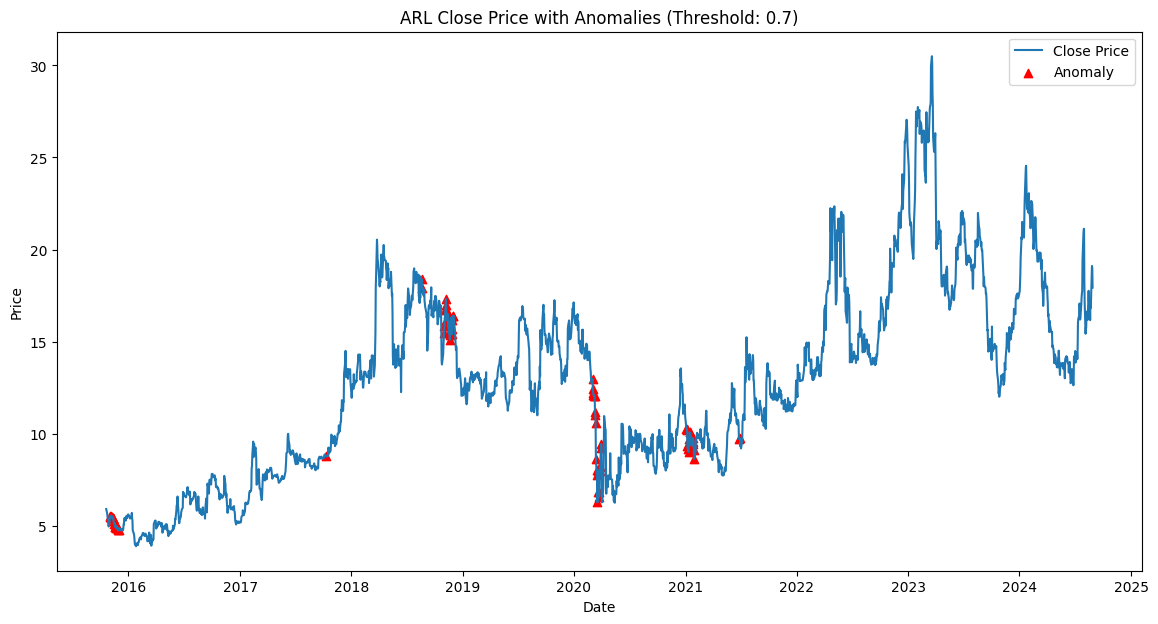

In [ ]:
plot_anomalies('ARL', df_final,'DBSCAN_Anomaly',0.7)

[*********************100%***********************]  1 of 1 completed


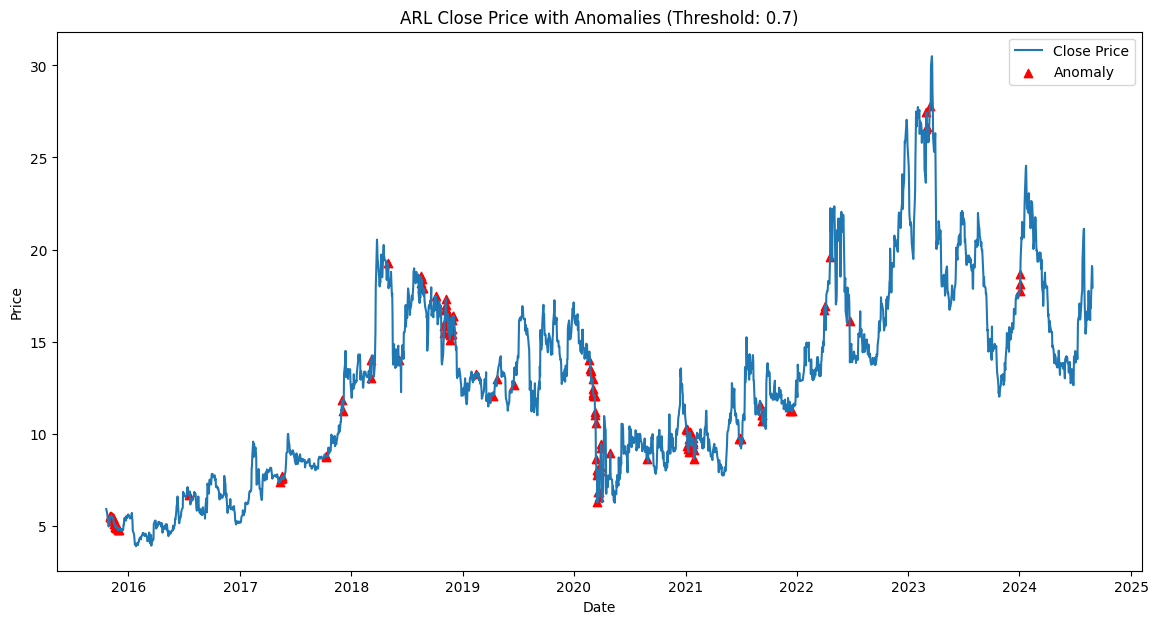

In [ ]:
plot_anomalies(
    ticker='ARL',
    df_anomalies=df_final,
    prob_column='DBSCAN_Anomaly_Probability',
    threshold=0.7
)

Distribution of DBSCAN Anomaly Score

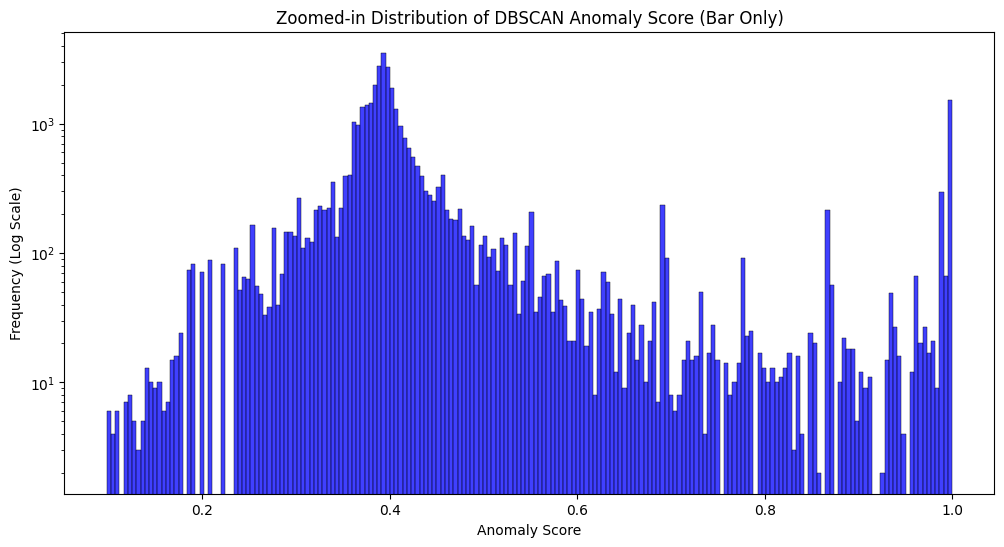

In [ ]:
# Plot the distribution of DBSCAN_Anomaly_Score with more bins for better granularity
plt.figure(figsize=(12, 6))
sns.histplot(df_final['DBSCAN_Anomaly_Probability'], bins=200, color='blue', kde=False)  # Increased bins for more detail

# Set x-axis limit to zoom in on the range of interest (e.g., 0 to 50 or adjust as needed)
# plt.xlim(0, 1)

# # Optionally, use a log scale for the y-axis if you want to see smaller frequencies better
plt.yscale('log')

# Add titles and labels
plt.title('Zoomed-in Distribution of DBSCAN Anomaly Score (Bar Only)')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency (Log Scale)')

# Show the plot
plt.show()



# Isolation Forest

Parameter Tuning and Defining Anomaly Scores

In [ ]:
from itertools import product
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Function to evaluate parameters based on anomaly score distribution
def evaluate_with_anomaly_scores(labels, anomaly_scores):
    # Only consider the anomaly scores for points labeled as anomalies (label == -1)
    anomaly_points_scores = anomaly_scores[labels == -1]

    # Define a metric based on anomaly scores (e.g., mean of anomaly scores for anomaly points)
    mean_anomaly_score = anomaly_points_scores.mean() if len(anomaly_points_scores) > 0 else 0
    return mean_anomaly_score

# Function to tune Isolation Forest parameters and detect anomalies
def tune_isolation_forest(group):
    X = group[features_dbscan].values  # Select only the features for Isolation Forest

    # Parameter grid for tuning
    param_grid_if = {
        'n_estimators': [100, 200],
        'max_samples': ['auto', 0.8],
        'contamination': [0.05, 0.1, 0.01, 0.02],
        'max_features': [1, 2]
    }

    # Generate all combinations of parameters
    param_names = list(param_grid_if.keys())
    param_values = list(param_grid_if.values())
    param_combinations = list(product(*param_values))

    best_combined_score = -np.inf
    best_params = None
    best_labels = None
    best_anomaly_scores = None

    # Dictionary to store scores for each parameter combination
    score_log = {}

    # Loop through each combination of parameters
    for param_combination in param_combinations:
        params = dict(zip(param_names, param_combination))

        # Apply Isolation Forest with the current set of parameters
        isolation_forest = IsolationForest(**params)
        labels = isolation_forest.fit_predict(X)
        anomaly_scores = isolation_forest.decision_function(X)

        # Skip evaluation if less than 2 clusters (or all data points are anomalies)
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(X, labels)
            davies_bouldin_avg = davies_bouldin_score(X, labels)

            # Evaluate using anomaly scores
            mean_anomaly_score = evaluate_with_anomaly_scores(labels, anomaly_scores)

            # Combine evaluations (adjust weights as needed)
            combined_score = silhouette_avg - davies_bouldin_avg + mean_anomaly_score

            # Log the scores for this parameter combination
            score_log[tuple(params.items())] = {
                "silhouette_score": silhouette_avg,
                "davies_bouldin_score": davies_bouldin_avg,
                "mean_anomaly_score": mean_anomaly_score,
                "combined_score": combined_score
            }

            # Update the best parameters if current metrics are better
            if combined_score > best_combined_score:
                best_combined_score = combined_score
                best_params = params
                best_labels = labels
                best_anomaly_scores = anomaly_scores

    # Assign the best labels and anomaly scores to the group
    if best_labels is not None and best_anomaly_scores is not None:
        group['IsolationForest'] = best_labels
        group['anomaly_score'] = best_anomaly_scores
        group['combined_score'] = best_combined_score  # Add combined score as a reference
    else:
        # If no suitable parameters were found, label all as non-anomalies (label = 0) and set anomaly_score to 0
        group['IsolationForest'] = 0
        group['anomaly_score'] = 0
        group['combined_score'] = 0

    return group

# Apply Isolation Forest with tuning to each group (monthly data)
df_anomalies_iforest = df_final.groupby('month', group_keys=False).apply(tune_isolation_forest)

# Change the 'IsolationForest_Anomaly' column to 1 when anomalies (label == -1) are detected
df_anomalies_iforest['IsolationForest_Anomaly'] = df_anomalies_iforest['IsolationForest'].apply(lambda x: 1 if x == -1 else 0)

# Display the updated DataFrame with changed labels
df_anomalies_iforest.head()


<ipython-input-20-3dadbbca1b30>:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_anomalies_iforest = df_final.groupby('month', group_keys=False).apply(tune_isolation_forest)


,date,tic,month,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,...,vix,sentiment,ATR,Price_Change,DBSCAN_Anomaly,DBSCAN_Anomaly_Probability,IsolationForest,anomaly_score,combined_score,IsolationForest_Anomaly
221,2015-10-20,ARL,2015-10,-0.765079,-0.165433,-0.279741,-0.738759,-0.772951,-1.237234,-0.603321,...,-0.545894,0.066251,-1.248227,0.028909,0,0.424842,1,0.085869,0.230488,0
222,2015-10-20,BH,2015-10,4.970078,-0.150340,1.081444,4.732676,5.041078,-0.173815,0.558980,...,-0.545894,0.066251,1.064206,0.117742,0,0.455700,1,0.002831,0.230488,0
223,2015-10-20,CIX,2015-10,-0.720587,-0.175494,-0.023806,-0.722450,-0.702156,-0.396184,-0.478956,...,-0.545894,0.066251,-0.201969,-0.005259,0,0.419646,1,0.147592,0.230488,0
224,2015-10-20,FDBC,2015-10,-0.460794,-0.156629,0.102387,-0.494830,-0.450392,2.439890,1.663509,...,-0.545894,0.066251,0.215591,0.062464,0,0.475433,1,0.078689,0.230488,0
225,2015-10-20,GEF,2015-10,-0.351318,1.898014,-0.099963,-0.330911,-0.312719,-0.457348,-0.715204,...,-0.545894,0.066251,1.740675,-0.245632,0,0.381456,1,0.085354,0.230488,0


Converting Scores to Probabilities

In [ ]:
from scipy.stats import norm

def compute_isolation_forest_probabilities(group):
    anomaly_scores = group['anomaly_score']

    # standardized
    mean_score = anomaly_scores.mean()
    std_score = anomaly_scores.std()
    group['IsolationForest_Anomaly_Z'] = (anomaly_scores - mean_score) / std_score

    # CDF
    group['IsolationForest_Anomaly_Probability'] = 1 - norm.cdf(group['IsolationForest_Anomaly_Z'])
    return group

df_anomalies_iforest = df_anomalies_iforest.groupby('tic', group_keys=False).apply(compute_isolation_forest_probabilities)

df_final['IsolationForest_Anomaly_Probability'] = df_anomalies_iforest['IsolationForest_Anomaly_Probability']


<ipython-input-21-d364c4801418>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_anomalies_iforest = df_anomalies_iforest.groupby('tic', group_keys=False).apply(compute_isolation_forest_probabilities)


[*********************100%***********************]  1 of 1 completed


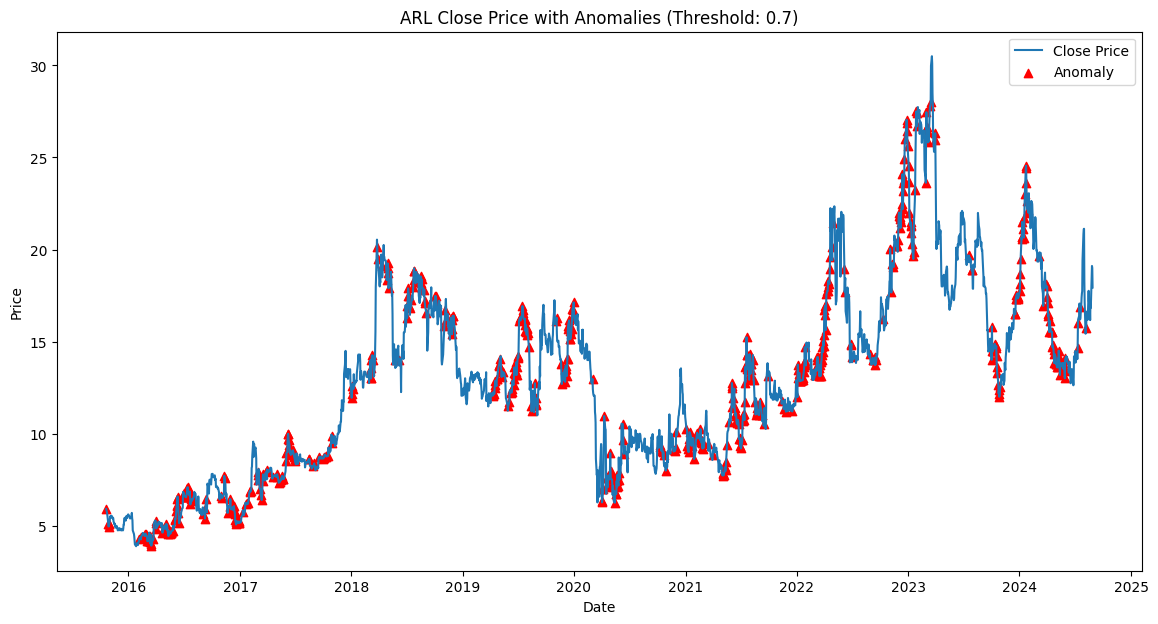

In [ ]:
plot_anomalies(
    ticker='ARL',
    df_anomalies=df_final,
    prob_column='IsolationForest_Anomaly_Probability',
    threshold=0.7
)

# One-Class SVM

Parameter Tuning and Defining Anomaly Scores

In [ ]:
from itertools import product
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

def tune_ocsvm(group):
    X_scaled = group[features_dbscan].values  # Select only the features for One-Class SVM

    # Expanded parameter grid for tuning
    param_grid_ocsvm = {
        'nu': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
    }

    # Generate all combinations of parameters
    param_names = list(param_grid_ocsvm.keys())
    param_values = list(param_grid_ocsvm.values())
    param_combinations = list(product(*param_values))

    best_params = None
    best_labels = None
    best_anomaly_ratio = 0.0
    best_scores = None

    # Loop through each combination of parameters
    for params in [dict(zip(param_names, comb)) for comb in param_combinations]:
        # Apply One-Class SVM with the current set of parameters
        svm = OneClassSVM(**params)
        svm.fit(X_scaled)
        labels = svm.predict(X_scaled)
        labels = np.where(labels == -1, 1, 0)  # Map anomalies (-1) to 1, normal data (1) to 0

        # Obtain decision function scores for each point
        scores = svm.decision_function(X_scaled)

        num_anomalies = np.sum(labels == 1)
        anomaly_ratio = num_anomalies / len(labels)

        # Print diagnostics
        print(f"Params: {params}, Anomalies detected: {num_anomalies}, Anomaly ratio: {anomaly_ratio:.2%}")

        # Skip if no anomalies detected
        if num_anomalies == 0:
            continue

        # Update best parameters based on desired criteria
        if 0 < anomaly_ratio <= 0.10 and anomaly_ratio > best_anomaly_ratio:
            best_anomaly_ratio = anomaly_ratio
            best_params = params
            best_labels = labels
            best_scores = scores

    # Assign the best labels and scores to the group
    if best_labels is not None and best_scores is not None:
        group['OCSVM'] = best_labels
        group['anomaly_score'] = best_scores
        print(f"Best params: {best_params}, Best anomaly ratio: {best_anomaly_ratio:.2%}")
    else:
        # If no suitable parameters were found, label all as non-anomalies (label = 0) and set anomaly_score to 0
        group['OCSVM'] = 0
        group['anomaly_score'] = 0
        print("No anomalies detected with any parameter combination.")

    return group

# Apply the tune_ocsvm function to each group (monthly data)
df_anomalies_ocsvm = df_final.groupby('month', group_keys=False).apply(tune_ocsvm)

# Assign the 'OCSVM' column to 'OCSVM_Anomaly'
df_anomalies_ocsvm['OCSVM_Anomaly'] = df_anomalies_ocsvm['OCSVM']

# Display the updated DataFrame with changed labels and anomaly scores
df_anomalies_ocsvm.head()


流式输出内容被截断，只能显示最后 5000 行内容。
Params: {'nu': 0.1, 'kernel': 'sigmoid', 'gamma': 1}, Anomalies detected: 40, Anomaly ratio: 10.23%
Params: {'nu': 0.1, 'kernel': 'sigmoid', 'gamma': 10}, Anomalies detected: 39, Anomaly ratio: 9.97%
Params: {'nu': 0.15, 'kernel': 'rbf', 'gamma': 'scale'}, Anomalies detected: 56, Anomaly ratio: 14.32%
Params: {'nu': 0.15, 'kernel': 'rbf', 'gamma': 'auto'}, Anomalies detected: 58, Anomaly ratio: 14.83%
Params: {'nu': 0.15, 'kernel': 'rbf', 'gamma': 0.01}, Anomalies detected: 58, Anomaly ratio: 14.83%
Params: {'nu': 0.15, 'kernel': 'rbf', 'gamma': 0.1}, Anomalies detected: 56, Anomaly ratio: 14.32%
Params: {'nu': 0.15, 'kernel': 'rbf', 'gamma': 1}, Anomalies detected: 101, Anomaly ratio: 25.83%
Params: {'nu': 0.15, 'kernel': 'rbf', 'gamma': 10}, Anomalies detected: 168, Anomaly ratio: 42.97%
Params: {'nu': 0.15, 'kernel': 'linear', 'gamma': 'scale'}, Anomalies detected: 58, Anomaly ratio: 14.83%
Params: {'nu': 0.15, 'kernel': 'linear', 'gamma': 'auto'}, Anomali

<ipython-input-23-ed76cd0355d0>:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_anomalies_ocsvm = df_final.groupby('month', group_keys=False).apply(tune_ocsvm)


,date,tic,month,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,...,vix,sentiment,ATR,Price_Change,DBSCAN_Anomaly,DBSCAN_Anomaly_Probability,IsolationForest_Anomaly_Probability,OCSVM,anomaly_score,OCSVM_Anomaly
221,2015-10-20,ARL,2015-10,-0.765079,-0.165433,-0.279741,-0.738759,-0.772951,-1.237234,-0.603321,...,-0.545894,0.066251,-1.248227,0.028909,0,0.424842,0.800181,0,2822.354076,0
222,2015-10-20,BH,2015-10,4.970078,-0.150340,1.081444,4.732676,5.041078,-0.173815,0.558980,...,-0.545894,0.066251,1.064206,0.117742,0,0.455700,0.691601,0,0.009518,0
223,2015-10-20,CIX,2015-10,-0.720587,-0.175494,-0.023806,-0.722450,-0.702156,-0.396184,-0.478956,...,-0.545894,0.066251,-0.201969,-0.005259,0,0.419646,0.336948,0,2070.302007,0
224,2015-10-20,FDBC,2015-10,-0.460794,-0.156629,0.102387,-0.494830,-0.450392,2.439890,1.663509,...,-0.545894,0.066251,0.215591,0.062464,0,0.475433,0.824750,0,14415.730085,0
225,2015-10-20,GEF,2015-10,-0.351318,1.898014,-0.099963,-0.330911,-0.312719,-0.457348,-0.715204,...,-0.545894,0.066251,1.740675,-0.245632,0,0.381456,0.572271,0,681.300146,0


In [ ]:
df_final['OCSVM_Anomaly']= df_anomalies_ocsvm['OCSVM_Anomaly']
df_final['OCSVM_Anomaly_Score']= df_anomalies_ocsvm['anomaly_score']
df_final.head()

,date,tic,month,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,...,turbulence,vix,sentiment,ATR,Price_Change,DBSCAN_Anomaly,DBSCAN_Anomaly_Probability,IsolationForest_Anomaly_Probability,OCSVM_Anomaly,OCSVM_Anomaly_Score
221,2015-10-20,ARL,2015-10,-0.765079,-0.165433,-0.279741,-0.738759,-0.772951,-1.237234,-0.603321,...,-0.322216,-0.545894,0.066251,-1.248227,0.028909,0,0.424842,0.800181,0,2822.354076
222,2015-10-20,BH,2015-10,4.970078,-0.150340,1.081444,4.732676,5.041078,-0.173815,0.558980,...,-0.322216,-0.545894,0.066251,1.064206,0.117742,0,0.455700,0.691601,0,0.009518
223,2015-10-20,CIX,2015-10,-0.720587,-0.175494,-0.023806,-0.722450,-0.702156,-0.396184,-0.478956,...,-0.322216,-0.545894,0.066251,-0.201969,-0.005259,0,0.419646,0.336948,0,2070.302007
224,2015-10-20,FDBC,2015-10,-0.460794,-0.156629,0.102387,-0.494830,-0.450392,2.439890,1.663509,...,-0.322216,-0.545894,0.066251,0.215591,0.062464,0,0.475433,0.824750,0,14415.730085
225,2015-10-20,GEF,2015-10,-0.351318,1.898014,-0.099963,-0.330911,-0.312719,-0.457348,-0.715204,...,-0.322216,-0.545894,0.066251,1.740675,-0.245632,0,0.381456,0.572271,0,681.300146


Converting Scores to Probabilities

In [ ]:
def compute_ocsvm_probabilities(group):
    anomaly_scores = group['anomaly_score']

    # standardized
    mean_score = anomaly_scores.mean()
    std_score = anomaly_scores.std()
    group['OCSVM_Anomaly_Z'] = (anomaly_scores - mean_score) / std_score

    # CDF
    group['OCSVM_Anomaly_Probability'] = 1 - norm.cdf(group['OCSVM_Anomaly_Z'])
    return group

df_anomalies_ocsvm = df_anomalies_ocsvm.groupby('tic', group_keys=False).apply(compute_ocsvm_probabilities)

df_final['OCSVM_Anomaly_Probability'] = df_anomalies_ocsvm['OCSVM_Anomaly_Probability']


<ipython-input-25-0af81f832861>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_anomalies_ocsvm = df_anomalies_ocsvm.groupby('tic', group_keys=False).apply(compute_ocsvm_probabilities)


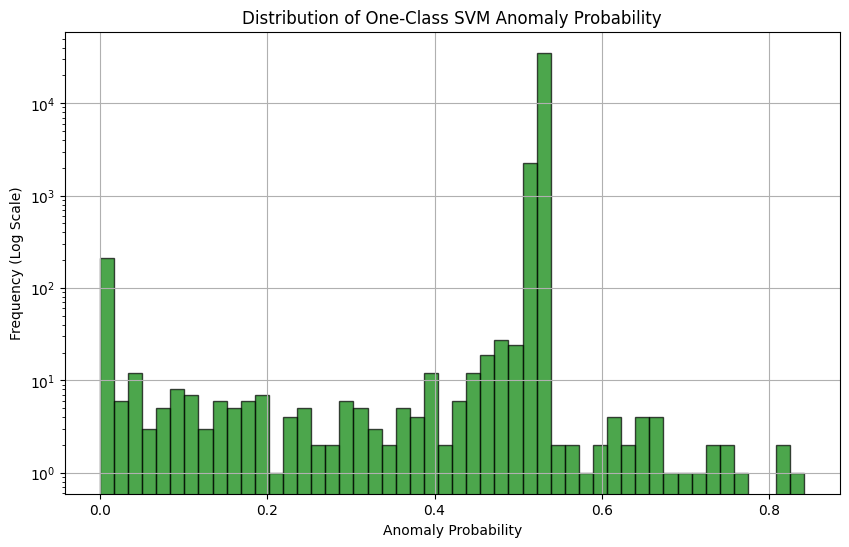

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_final['OCSVM_Anomaly_Probability'], bins=50, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of One-Class SVM Anomaly Probability')
plt.xlabel('Anomaly Probability')
plt.ylabel('Frequency (Log Scale)')
plt.yscale('log')
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


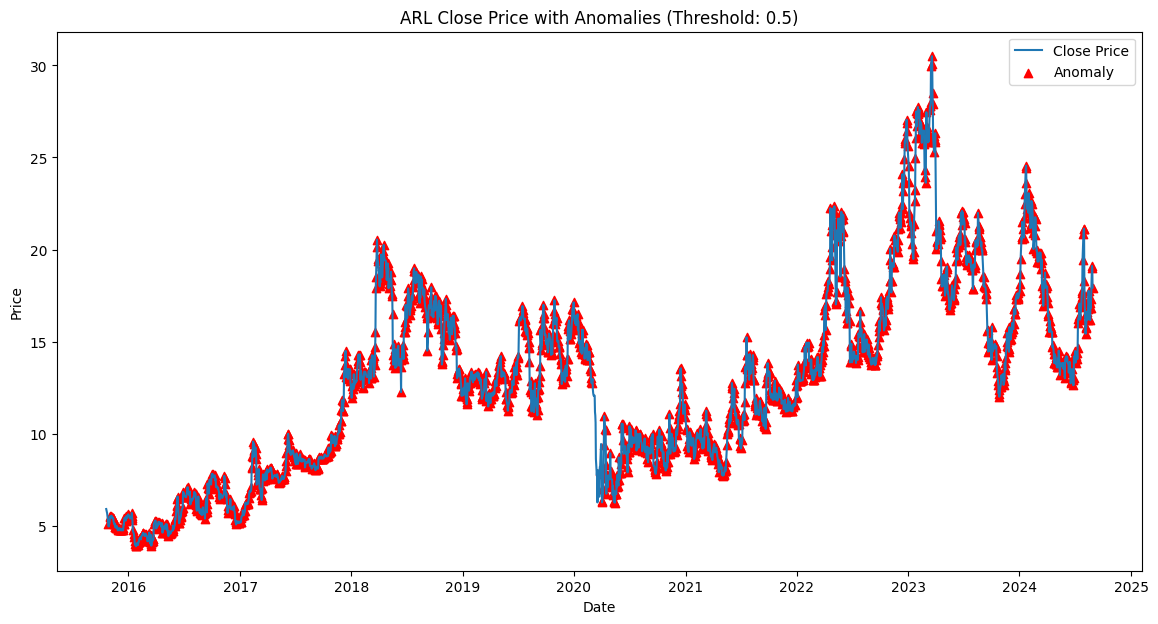

In [ ]:
plot_anomalies(
    ticker='ARL',
    df_anomalies=df_final,
    prob_column='OCSVM_Anomaly_Probability',
    threshold=0.5
)

In [ ]:
df_final.to_csv('df_final.csv', index=False)
